## Import Dependencies and Data

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, LeakyReLU, Dropout, BatchNormalization, UpSampling2D
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img
import threading
from matplotlib import pyplot as plt
import numpy as np
import os

c:\Users\johnn\miniconda3\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

In [4]:
ds.as_numpy_iterator().next()['label']

2

## Viz Data and Build Dataset

In [5]:
dataiterator = ds.as_numpy_iterator()

In [6]:
# Getting data out of the pipeline
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

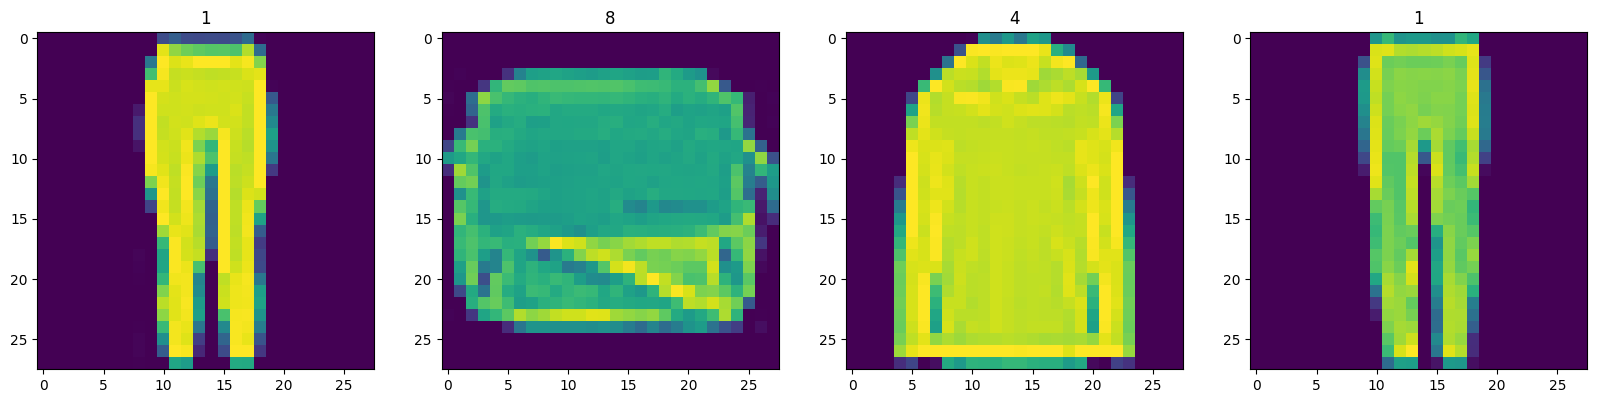

In [7]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [8]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

In [9]:
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [10]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## Build Neural Network

### Generator

In [11]:
def build_generator(): 
    model = Sequential()
    model.add(Dense(7*7*128, input_dim = 128))   # Input dimension 128 for random noise
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))  # Reshape into (7, 7, 128)

    # Transposed Convolutional Block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # Transposed Convolutional Block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    #model.add(BatchNormalization()) # Normalize
    model.add(LeakyReLU(0.2))

    # Convolutional Block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional Block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Final Conv Layer (1 channel, sigmoid activation)
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [12]:
generator = build_generator()

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 5s 5s/step


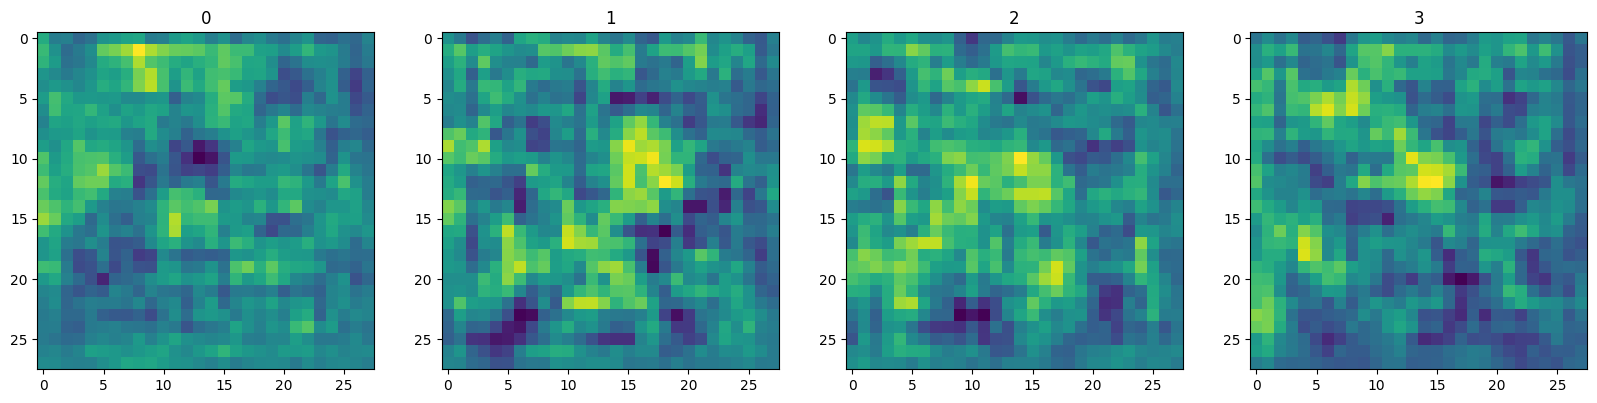

In [14]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img):
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

### Discriminator

In [15]:
def build_discriminator():
    model = Sequential()
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))  # First layer needs input_shape
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))  # Slightly lower dropout rate
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [16]:
discriminator = build_discriminator()

In [17]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

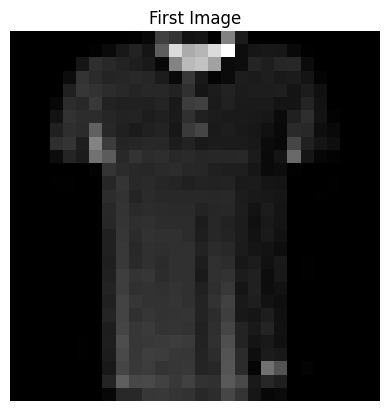

In [18]:
# Assuming you have already set up your dataiterator
dataiterator = ds.as_numpy_iterator()

# Fetch a sample batch from the dataset
sample = dataiterator.next()  # Get the next batch of images
img = sample  # Assign the images to img (this will be a batch of images)

# Now you can access the first image in the batch
first_image = img[0]  # Access the first image

# Visualize the first image (if desired)
import matplotlib.pyplot as plt

plt.imshow(np.squeeze(first_image), cmap='gray')
plt.axis('off')
plt.title("First Image")
plt.show()

In [19]:
img.shape

(128, 28, 28, 1)

In [20]:
discriminator.predict(img)

4/4 [==============================] - 0s 2ms/step


array([[0.50214416],
       [0.5019136 ],
       [0.50735205],
       [0.4995119 ],
       [0.50193316],
       [0.5052204 ],
       [0.49754474],
       [0.51159143],
       [0.5076265 ],
       [0.4943385 ],
       [0.5078848 ],
       [0.5053861 ],
       [0.5001689 ],
       [0.5033419 ],
       [0.5081269 ],
       [0.5055511 ],
       [0.5023309 ],
       [0.50274974],
       [0.50927454],
       [0.5021221 ],
       [0.5073518 ],
       [0.5099097 ],
       [0.4988778 ],
       [0.49570188],
       [0.50695497],
       [0.5146466 ],
       [0.4959449 ],
       [0.50635856],
       [0.5035266 ],
       [0.49738973],
       [0.5036752 ],
       [0.5063008 ],
       [0.5055602 ],
       [0.4995098 ],
       [0.5101012 ],
       [0.50971466],
       [0.508869  ],
       [0.50412464],
       [0.49541414],
       [0.5004884 ],
       [0.5070703 ],
       [0.5049113 ],
       [0.49740157],
       [0.49848837],
       [0.50435287],
       [0.49958003],
       [0.51226026],
       [0.508

In [21]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            y_realfake = tf.concat([tf.ones_like(yhat_real), tf.zeros_like(yhat_fake)], axis=0)
            
            # Calculate discriminator loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            gen_images = self.generator(tf.random.normal((128, 128)), training=True)
            predicted_labels = self.discriminator(gen_images, training=True)
            total_g_loss = self.g_loss(tf.ones_like(predicted_labels), predicted_labels) 

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss": total_d_loss, "g_loss": total_g_loss}

In [22]:
# If you have already compiled fashion_gan, there's no need to create fashgan
# Simply use fashion_gan for your further steps.

# Alternatively, if you need a separate instance with the same configuration:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [23]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [24]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [25]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [26]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

## Training

In [27]:
hist = fashgan.fit(ds, epochs=2000, callbacks=[ModelMonitor()])

Epoch 1/2000
469/469 [==============================] - 48s 96ms/step - d_loss: 0.5445 - g_loss: 1.0622
Epoch 2/2000
469/469 [==============================] - 44s 94ms/step - d_loss: 0.3633 - g_loss: 3.4722
Epoch 3/2000
469/469 [==============================] - 44s 95ms/step - d_loss: 0.2790 - g_loss: 2.5708
Epoch 4/2000
469/469 [==============================] - 45s 96ms/step - d_loss: 0.2751 - g_loss: 2.6440
Epoch 5/2000
469/469 [==============================] - 45s 96ms/step - d_loss: 0.2726 - g_loss: 2.6502
Epoch 6/2000
469/469 [==============================] - 45s 97ms/step - d_loss: 0.2718 - g_loss: 2.6437
Epoch 7/2000
469/469 [==============================] - 45s 96ms/step - d_loss: 0.2708 - g_loss: 2.6434
Epoch 8/2000
469/469 [==============================] - 45s 96ms/step - d_loss: 0.2698 - g_loss: 2.6428
Epoch 9/2000
469/469 [==============================] - 45s 96ms/step - d_loss: 0.2691 - g_loss: 2.6480
Epoch 10/2000
469/469 [==============================] - 45s 96m

### Metrics

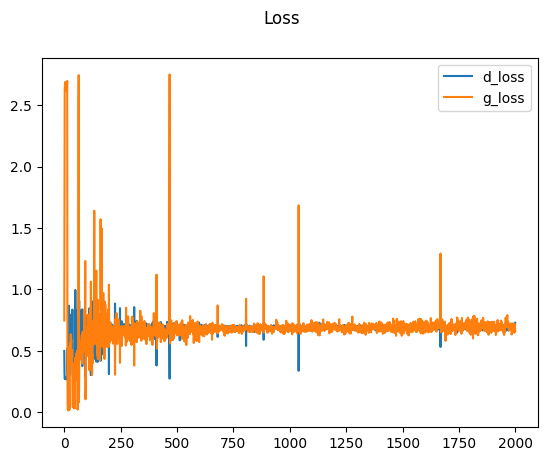

In [28]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

## Test Out the Generator

### Generate Images

In [ ]:
generator.load_weights(r'C:\Users\johnn\Downloads\My Notebooks\GAN\generator.h5')

In [30]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 432ms/step


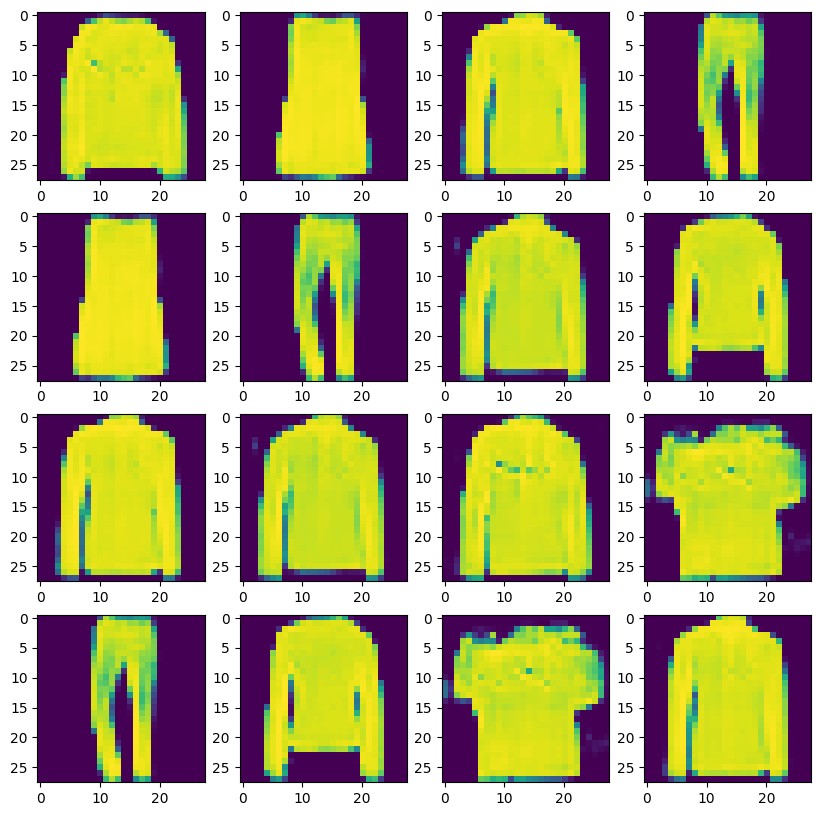

In [31]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [32]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')